In [1]:
# ================================================================================================================
# Figure 2: Spatial distribution of bootstrap percentiles relative to 100-year return levels
# Purpose: Illustrate spatial variability of 1st and 99th percentile bootstrap estimates and compare with "true"
#          100-year return level derived from the full 3,226-year Weather@Home dataset.
# Inputs: Weather@Home Rx1d dataset (stationary 2006–2015 ensemble), 3226 model years.
# Outputs: 1x3 subplot showing 1st percentile (% of 100-year), 100-year return level, 99th percentile (% of 100-year)
# ================================================================================================================

In [2]:
# ---------------------------------------------------------------
# Section 1: Import required libraries
# ---------------------------------------------------------------

from scipy.stats import genextreme as gev
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Set default plot font for consistency
plt.rcParams["font.family"] = "Arial"

-------

In [3]:
# ---------------------------------------------------------------
# Section 2: Load Rx1d rainfall data
# ---------------------------------------------------------------

# Load the Weather@Home Rx1d data (stationary 2006–2015 ensemble)
rainfall_data = xr.open_dataset('../Weather@home Data/Aotearoa Rx1d Weather@home Data Specified Land-Sea Mask - Stationary Climate.nc')['item5216_daily_mean']

# Convert to numpy arrays
rx1d_data = np.array(rainfall_data)
latitude = np.array(rainfall_data['global_latitude0'])
longitude = np.array(rainfall_data['global_longitude0'])

-------

In [4]:
# ---------------------------------------------------------------
# Section 3: Define bootstrap resampling function
# ---------------------------------------------------------------

def bootstrap_random_sample(import_data):
    """
    Perform bootstrap resampling of Rx1d data to estimate the distribution of worst-in-century (WIC).

    Parameters
    ----------
    import_data : Input series of annual Rx1d values for a given grid cell.

    Returns
    -------
    df_result : DataFrame containing the maximum value from each of 10,000 bootstrap samples (column 'WIC').
    """

    num_samples = 100        # Number of data points per bootstrap sample
    num_iterations = 10000   # Total number of bootstrap iterations
    
    # Perform bootstrap and store results
    result = [] 

    if import_data is not None:
        for _ in range(num_iterations):
            bootstrap_sample = resample(import_data, n_samples=num_samples, replace=True)
            result.append(np.max(bootstrap_sample))
    else:
        result = None

    # Convert results to a DataFrame
    df_result = pd.DataFrame()
    df_result['WIC'] = pd.DataFrame(result) if result is not None else pd.Series([np.nan] * num_samples)

    return df_result

-------

In [5]:
# ---------------------------------------------------------------
# Section 4: Compute spatial maps of bootstrap percentiles and 100-year return level
# ---------------------------------------------------------------

# Define number of latitudes and longitudes within the data for spatial map
n_lat, n_lon = rx1d_data.shape[1], rx1d_data.shape[2]

# Initialize arrays for maps for 100-year return level, and 99th percentile and 1st percentile differences from 100-year return level
hundred_years_return_levels = np.full((n_lat, n_lon), np.nan)
differences_to_99th_percentiles = np.full((n_lat, n_lon), np.nan)
differences_to_1st_percentiles = np.full((n_lat, n_lon), np.nan)

# Loop over each grid cell
for i in range(0, n_lat):
        for j in range(0, n_lon):

            # Selecting annual maximum 1-day rainfall data in a grid cell
            grid_cell_rx1d = rx1d_data[:,i,j]
            
            # Check if all values are NaN
            if np.all(np.isnan(grid_cell_rx1d)):
                continue  # Skip this iteration if all values are NaN

            # Bootstrap WIC distribution
            bootstrap_grid_cell_rx1d = bootstrap_random_sample(grid_cell_rx1d)

            # Compute 1st and 99th percentiles from bootstrap
            p1 = np.percentile(bootstrap_grid_cell_rx1d['WIC'] , 1)
            p99 = np.percentile(bootstrap_grid_cell_rx1d['WIC'] , 99)
            
            # Fit GEV to full 3,226-year dataset and estimate "true" 100-year return level
            shape, loc, scale = gev.fit(grid_cell_rx1d, 0) # GEV fitting to the full 3226-year dataset            
            return_level_100_years = gev.ppf(1 - 1/100, shape, loc=loc, scale=scale)
            hundred_years_return_levels[i,j] = return_level_100_years
            
            # Estimate 99th percentile and 1st percentile differences from 100-year return level
            differences_to_99th_percentiles[i,j] = p99 - return_level_100_years
            differences_to_1st_percentiles[i,j] = return_level_100_years - p1

-------

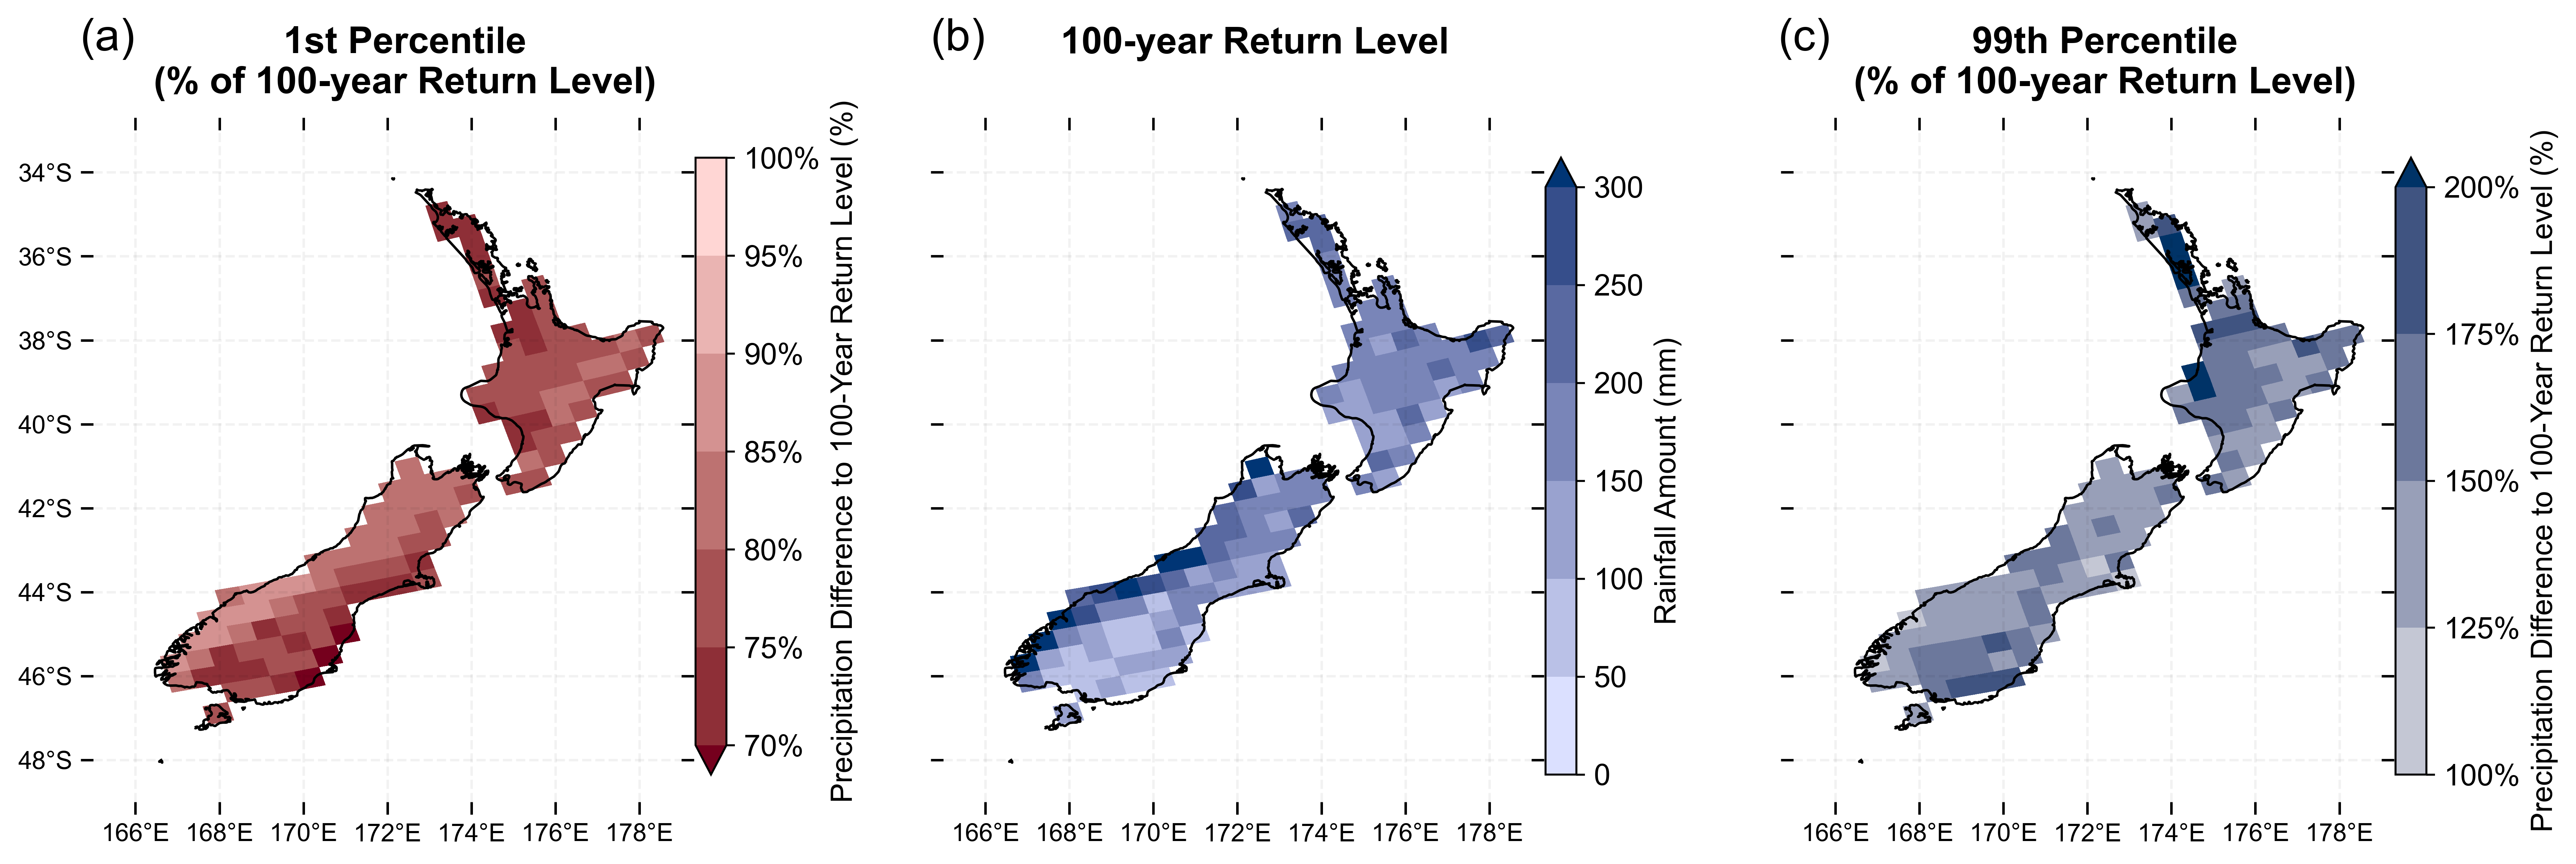

In [6]:
# ---------------------------------------------------------------
# Section 5: Plot spatial maps
# ---------------------------------------------------------------

# Create the figure and the 1x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=500, subplot_kw={'projection': ccrs.PlateCarree()})

# Prepare datasets for plotting
percentage_differences_to_99th_percentiles = (((differences_to_99th_percentiles) / hundred_years_return_levels) * 100) + 100
percentage_differences_to_1st_percentiles = (((differences_to_1st_percentiles * -1) / hundred_years_return_levels) * 100) + 100
datasets = [percentage_differences_to_1st_percentiles, hundred_years_return_levels, percentage_differences_to_99th_percentiles]

# Titles for each subplot
titles = ['1st Percentile\n(% of 100-year Return Level)', '100-year Return Level\n', '99th Percentile\n(% of 100-year Return Level)']

# Gridlines Settings
label_left = [True, False, False]
label_right = [False, False, False]
label_top = [False, False, False]
label_bottom = [True, True, True]

# Define colormaps and bounds
bounds_list = ([70, 75, 80, 85, 90, 95, 100],
               [0, 50, 100, 150, 200, 250, 300],
               [100, 125, 150, 175, 200])
cmap_list = (ListedColormap(['#8e2f37', '#a65153', '#bd7271', '#d49291', '#eab4b2', '#ffd6d4']),
             ListedColormap(['#dbe0ff', '#bac1e7', '#99a2cf', '#7985b8', '#5969a1', '#364e8b']),
             ListedColormap(['#c4c7d4', '#989fb8', '#6c789c', '#405481']))
cmap_low_extremes_list = ('#75001d', None, None)
cmap_high_extremes_list = (None, '#003575', '#003367')


# Loop over subplots
for i, ax in enumerate(axes):
    # Each subplot title
    ax.set_title(titles[i], fontsize=15, pad=15, x=0.53, weight='bold')

    # Update the data for each subplot
    selected_data = datasets[i]
    bounds = bounds_list[i]
    cmap = cmap_list[i]
    cmap.set_extremes(under=cmap_low_extremes_list[i], over=cmap_high_extremes_list[i])
    
    # Gridlines and map settings
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.05, linestyle='--', draw_labels=False)
    # Add tick marks (small dashes) for latitudes and longitudes
    ax.tick_params(axis='both', which='both', direction='out', length=5, width=1, labelsize=10)
    ax.set_xticks(np.arange(160, 180, 2), crs=ccrs.PlateCarree())  # Longitude ticks
    ax.set_yticks(np.arange(-50, -30, 2), crs=ccrs.PlateCarree())  # Latitude ticks
    lon_formatter = LONGITUDE_FORMATTER
    lat_formatter = LATITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(left=True, bottom=True, right=True, top=True, 
                   labelleft=label_left[i], labelright=label_right[i], labeltop=label_top[i], labelbottom=label_bottom[i])
    ax.set_extent([165, 179, -49, -33], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    # Remove frame
    ax.spines['geo'].set_visible(False)
    
    # Plot data for each subplot
    plot_data = ax.pcolormesh(longitude, latitude, selected_data, transform=ccrs.PlateCarree(), cmap=cmap, norm=BoundaryNorm(bounds, cmap.N))

    # Add colorbar for each subplot
    if i == 0:
        cbar = fig.colorbar(plot_data, ax=ax, orientation='vertical', extend='min', pad=0.02, shrink=0.8, ticks=bounds)
        cbar.ax.set_yticklabels(['70%', '75%', '80%', '85%', '90%', '95%', '100%'])
        cbar.set_label('Precipitation Difference to 100-Year Return Level (%)', fontsize=12)
    elif i == 1:
        cbar = fig.colorbar(plot_data, ax=ax, orientation='vertical', extend='max', pad=0.02, shrink=0.8, ticks=bounds)
        cbar.set_label('Rainfall Amount (mm)', fontsize=12)
    elif i == 2:
        cbar = fig.colorbar(plot_data, ax=ax, orientation='vertical', extend='max', pad=0.02, shrink=0.8, ticks=bounds)
        cbar.ax.set_yticklabels(['100%', '125%', '150%', '175%', '200%'])
        cbar.set_label('Precipitation Difference to 100-Year Return Level (%)', fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    
# Add subplot labels
axes[0].text(0.065, 0.96, '(a)', transform=plt.gcf().transFigure, fontsize=18, va='top', ha='left')
axes[1].text(0.381, 0.96, '(b)', transform=plt.gcf().transFigure, fontsize=18, va='top', ha='left')
axes[2].text(0.696, 0.96, '(c)', transform=plt.gcf().transFigure, fontsize=18, va='top', ha='left')
    
# Adjust layout to ensure everything fits well
plt.tight_layout()
plt.show()

-------